<a href="https://colab.research.google.com/github/tomasborrella/TheValley/blob/main/notebooks/mds%2B3/spark02/Spark_ETL_Ejercicio_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spark ETL Ejercicio Resuelto

Notebook por [Tomás Borrella Martín](https://www.linkedin.com/in/tomasborrella/).

### Enlaces de interés
*   [Slides de presentación](https://docs.google.com/presentation/d/1QApmeKaSXYb8dZdN8WahO4cZ6cft7OupncHW_DijsdA/edit?usp=sharing)

# Enunciado

Partimos de 2 datasets con información de las máquinas de una planta industrial (cada uno de los datasets ha sido generado por un sistema distinto, por lo que tienen distinto formato):

1.   Incidencias (incidencias_maquinas.csv)

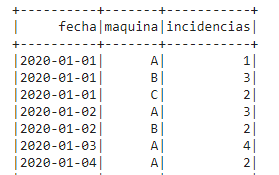

2.   Producción (produccion_maquinas.csv)

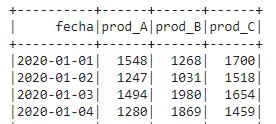

Vamos a realizar una ETL en Spark para obtener un dataset como el siguiente y guardarlo para futuros usos:

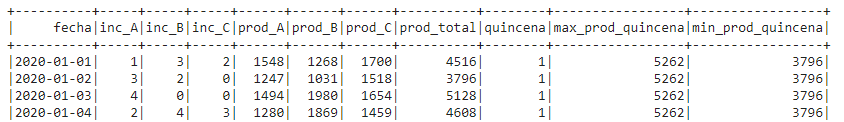

## Pasos:

1.   **E**xtract

    1.   Descargar datos. Desde GitHub al entorno de Colab:
    
      `!wget -P /content/data 'https://raw.githubusercontent.com/tomasborrella/TheValley/main/data/spark02/etl/incidencias_maquinas.csv'`

      `!wget -P /content/data 'https://raw.githubusercontent.com/tomasborrella/TheValley/main/data/spark02/etl/produccion_maquinas.csv'`

    2.   Crear DataFrames. Se creará un DataFrame para cada uno de los archivos. Hay que asegurarse que los campos tienen el tipo correcto (las fechas el tipo `DateType` y los números el tipo `IntegerType`).

2.   **T**ransform

    1. Pivotar. Pivotar la tabla de incidencias para conseguir una única fila por día y cada una de las máquinas en una columna.
    2.   Join. Unir los DataFrames de incidencias y producción.
    3.   Crear columnas:

        1. Crear 'prod_total'. Se crea la columna 'prod_total' con la suma de la producción de cada máquina para ese día.
        
        2. Crear 'quincena'. Se crea la columna 'quincena' (1 si el día es mayor que quince y 2 si el día es menor o igual que quince). Recomendado hacerlo con una UDF (para practicar), aunque en este caso tan sencillo se podría hacer con la función `when`.

        3. Crear 'max_prod_quincena' y 'min_prod_quincena'. Hay que crearlas para todas las filas con el máximo y el mínimo de producción de una quincena respectivamente (utilizando funciones de ventana).

3.   **L**oad

    1.   Guardar el archivo. Utilizando el formato `parquet`.
    2.   Comprobar. Cargar el archivo de nuevo para asegurarnos que lo que se ha guardado es correcto.



# 0.1 - Instalación Spark

In [ ]:
# Install JAVA
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# Install Spark
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
# Install findspark
!pip install -q findspark

In [ ]:
# Environment variables
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [ ]:
# Find spark
import findspark
findspark.init()

In [ ]:
# PySpark 
!pip install pyspark==3.1.2

# 0.2 - Spark Session
Punto de entrada de la aplicación de Spark

In [ ]:
# Imports
from pyspark.sql import SparkSession

In [ ]:
# Create Spark Session
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("Spark Dataframes")
         .getOrCreate()
)

# 1 - Extract

## 1 - Descargar datos

Desde GitHub al entorno de Colab


In [ ]:
!wget -P /content/data 'https://raw.githubusercontent.com/tomasborrella/TheValley/main/data/spark02/etl/incidencias_maquinas.csv'
!wget -P /content/data 'https://raw.githubusercontent.com/tomasborrella/TheValley/main/data/spark02/etl/produccion_maquinas.csv'

## 2 - Crear DataFrames. 

Se creará un DataFrame para cada uno de los archivos. Hay que asegurarse que los campos tienen el tipo correcto (las fechas el tipo DateType y los números el tipo IntegerType).

In [ ]:
# Creamos el DataFrame de incidencias

from pyspark.sql.types import StructType, IntegerType, StringType, DateType

schema = (
    StructType() 
    .add("fecha",DateType(),True) 
    .add("maquina",StringType(),True) 
    .add("incidencias",IntegerType(),True) 
)
 
incidencias = spark.read.csv('/content/data/incidencias_maquinas.csv', sep=';', header=True, schema=schema)

In [ ]:
incidencias.show()

In [ ]:
# Creamos el DataFrame de producción

schema = (
    StructType() 
    .add("fecha",DateType(),True) 
    .add("prod_A",IntegerType(),True) 
    .add("prod_B",IntegerType(),True)
    .add("prod_C",IntegerType(),True)  
)
 
produccion = spark.read.csv('/content/data/produccion_maquinas.csv', sep=';', header=True, schema=schema)

In [ ]:
produccion.show(31)

# 2 - Transform

## 1 - Pivotar

Pivotar la tabla de incidencias para conseguir una única fila por día y cada una de las máquinas en una columna.

In [ ]:
from pyspark.sql import functions as F

# Pivotamos
df = (incidencias
    .groupby("fecha", "maquina")
    .pivot("maquina")
    .sum("incidencias")
    .orderBy("fecha")
    .groupBy("fecha")
    .agg(F.max(F.col("A")).alias("inc_A"), 
         F.max(F.col("B")).alias("inc_B"), 
         F.max(F.col("C")).alias("inc_C"))
    .orderBy("fecha")
    .na.fill(value=0, subset=["inc_A", "inc_B", "inc_C"])
    )

df.show(31)

## 2 - Join

Unir los DataFrames de incidencias y producción.

In [ ]:
df = df.join(produccion, on="fecha").orderBy("fecha")
df.show(31)

## 3 - Crear columnas

### 1 - Crear 'prod_total'

Se crea la columna 'prod_total' con la suma de la producción de cada máquina para ese día.




In [ ]:
df = df.withColumn('prod_total', F.col('prod_A') + F.col('prod_B') + F.col('prod_C'))
df.show()

### 2 - Crear columna "quincena" 

Se crea la columna 'quincena' (1 si el día es mayor que quince y 2 si el día es menor o igual que quince). Recomendado hacerlo con una UDF (para practicar), aunque en este caso tan sencillo se podría hacer con la función `when`.

#### Opción 1: Usando UDF

Forma pedida en el ejercicio para practicar con UDF

In [ ]:
from pyspark.sql.types import IntegerType

quincena = F.udf(lambda s: 2 if s > 15 else 1, IntegerType())

In [ ]:
df = df.withColumn('quincena', quincena(F.dayofmonth(F.col("fecha"))))
df.show()

#### Opción 2: Usando 'when'

Opcional. Solo si sobra tiempo.

In [ ]:
df.withColumn('quincena', F.when(F.dayofmonth(F.col("fecha")) > 15, 2).otherwise(1)).show()

### 3 - Crear 'max_prod_quincena' y 'min_prod_quincena'. 

Hay que crearlas para todas las filas con el máximo y el mínimo de producción de una quincena respectivamente (utilizando funciones de ventana).

In [ ]:
from pyspark.sql.window import Window

ventana_quincena =  Window.partitionBy(F.col("quincena"))

df = (df
      .withColumn("max_prod_quincena", F.max(F.col("prod_total")).over(ventana_quincena))
      .withColumn("min_prod_quincena", F.min(F.col("prod_total")).over(ventana_quincena))
      )

df.show()

# 3 - Load

## 1 - Guardar el archivo

Utilizando el formato `parquet`.

In [ ]:
df.write.parquet("/content/data/df_completo.parquet") 

## 2 - Comprobar. 

Cargar el archivo de nuevo para asegurarnos que lo que se ha guardado es correcto.

In [ ]:
# Comprobar
df_comprobacion = spark.read.parquet("/content/data/df_completo.parquet")

In [ ]:
df_comprobacion.count

In [ ]:
df_comprobacion.dtypes

# Spark Stop

In [ ]:
spark.stop()